In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.color import rgb2gray
import cv2
import random
import math

In [2]:
INT32_MAX = 2147483647
COLOR_FOREGROUND = 255
COLOR_BACKGROUND = 0

def showimg(_img, _title="Obraz"):
    print(_img.shape, _img.dtype)
    plt.imshow(_img, cmap="gray")
    plt.axis('off')
    plt.suptitle(_title)
    plt.show()

(344, 549) uint8


C:\Users\Machina\Anaconda3\envs\py36\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


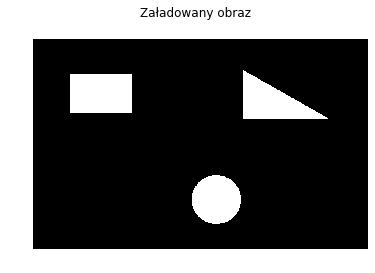

In [3]:
img = io.imread("./pattern1.png")
th = 128
img = img_as_ubyte(rgb2gray(img))
th, bim = cv2.threshold(img, thresh=th, maxval=255, type=cv2.THRESH_BINARY_INV)
showimg(bim, _title="Załadowany obraz")

Segmentacja trwała 6.347317 sekund
Liczba obiektów na obrazie: 3
(344, 549, 3) uint8


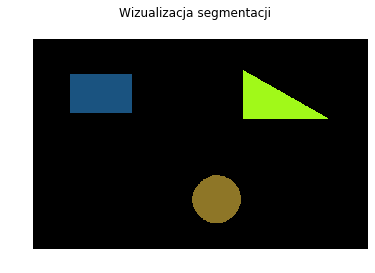

In [5]:
def get_max_obj_no(segment_table):
    max_segment_no = 0
    for i in range(segment_table.shape[0]):
        for j in range(segment_table.shape[1]):
            if(segment_table[i][j] > max_segment_no):
                max_segment_no = segment_table[i][j]
    return max_segment_no

def visualize(segment_table):
    max_segment_no = get_max_obj_no(segment_table)
    vimg = np.zeros([segment_table.shape[0], segment_table.shape[1], 3], dtype=np.uint8)
    segment_colors = [None] * (max_segment_no + 1)
    segment_colors[0] = (0,0,0)
    for i in range(1, max_segment_no + 1):
        segment_colors[i] = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
    
    for x in range(vimg.shape[0]):
        for y in range(vimg.shape[1]):
            for z in range(vimg.shape[2]):
                vimg[x][y][z] = segment_colors[segment_table[x][y]][z]
    return vimg

def is_in_image(shape, px=0, py=0):
    return ((px>=0) and (px < shape[0]) and (py >= 0) and (py < shape[1]))

def get_neighbouring(segment_table, px=0, py=0):
    if (segment_table[px-1][py-1] != 0) and is_in_image(segment_table.shape, px=px-1, py=py-1):      # top left
        return segment_table[px-1][py-1]
    elif (segment_table[px-1][py] != 0) and is_in_image(segment_table.shape, px=px-1, py=py):     # top center
        return segment_table[px-1][py]
    elif (segment_table[px-1][py + 1] != 0) and is_in_image(segment_table.shape, px=px-1, py=py+1):  # top right
        return segment_table[px-1][py+1]
    elif (segment_table[px][py+1] != 0) and is_in_image(segment_table.shape, px=px, py=py+1):     # middle right
        return segment_table[px][py+1]
    elif (segment_table[px+1][py+1] != 0) and is_in_image(segment_table.shape, px=px+1, py=py+1):    # bottom right
        return segment_table[px+1][py+1]
    elif (segment_table[px+1][py] != 0) and is_in_image(segment_table.shape, px=px+1, py=py):     # bottom center
        return segment_table[px+1][py]
    elif (segment_table[px+1][py-1] != 0) and is_in_image(segment_table.shape, px=px+1, py=py-1):    # bottom left
        return segment_table[px+1][py-1]
    elif (segment_table[px][py-1] != 0) and is_in_image(segment_table.shape, px=px, py=py-1):     # middle left
        return segment_table[px][py-1]
    else:
        return 0

def get_min_neighbouring(segment_table, px=0, py=0):
    neighbouring = []
    min_neighbouring = INT32_MAX
    
    if is_in_image(segment_table.shape, px=px-1, py=py-1):      # top left
        neighbouring.append(segment_table[px-1][py-1])
    if is_in_image(segment_table.shape, px=px-1, py=py):     # top center
        neighbouring.append(segment_table[px-1][py])
    if is_in_image(segment_table.shape, px=px-1, py=py+1):  # top right
        neighbouring.append(segment_table[px-1][py+1])
    if is_in_image(segment_table.shape, px=px, py=py+1):     # middle right
        neighbouring.append(segment_table[px][py+1])
    if is_in_image(segment_table.shape, px=px+1, py=py+1):    # bottom right
        neighbouring.append(segment_table[px+1][py+1])
    if is_in_image(segment_table.shape, px=px+1, py=py):     # bottom center
        neighbouring.append(segment_table[px+1][py])
    if is_in_image(segment_table.shape, px=px+1, py=py-1):    # bottom left
        neighbouring.append(segment_table[px+1][py-1])
    if is_in_image(segment_table.shape, px=px, py=py-1):     # middle left
        neighbouring.append(segment_table[px][py-1])
    
    for i in range(len(neighbouring)):
        if neighbouring[i] < min_neighbouring:
            min_neighbouring = neighbouring[i]
    return 0 if min_neighbouring == INT32_MAX else min_neighbouring
    
def try_joining_objects(segment_table):
    for i in range(segment_table.shape[0]):
        for j in range(segment_table.shape[1]):
            min_neighbour = get_min_neighbouring(segment_table, px=i, py=j)
            if min_neighbour:
                segment_table[i][j] = min_neighbour
    return segment_table

def discard_small_objects(segment_table):
    small_obj_threshold_pct = 0.005
    image_size = segment_table.shape[0] * segment_table.shape[1]
    small_obj_threshold_count = math.floor(small_obj_threshold_pct * image_size)
    unique_elements, counts_elements = np.unique(segment_table, return_counts=True)
    tobediscarded = [False] * len(unique_elements)
    for i in range(1, len(unique_elements)):
        if counts_elements[i] <= small_obj_threshold_count:
            tobediscarded[i] = True
    discard_dict = dict(zip(unique_elements, tobediscarded))
    for i in range(segment_table.shape[0]):
        for j in range(segment_table.shape[1]):
            if discard_dict.get(segment_table[i][j]) == True:
                segment_table[i][j] = 0
    return segment_table
    
def segment_by_region_growing(im):
    object_num = 1
    segment_table = np.zeros(im.shape, dtype=np.uint32)
    global COLOR_FOREGROUND, COLOR_BACKGROUND
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i][j] == COLOR_FOREGROUND:
                first_neighbour = get_neighbouring(segment_table, px=i, py=j)
                if first_neighbour != 0:
                    segment_table[i][j] = first_neighbour
                else:
                    segment_table[i][j] = object_num
                    object_num += 1
            else:
                continue
    for i in range(5):
        try_joining_objects(segment_table)
    discard_small_objects(segment_table)
    return segment_table

table = segment_by_region_growing(bim)
print("Segmentacja trwała %f sekund" % time_delta)
print("Liczba obiektów na obrazie: %d" % get_max_obj_no(table))

showimg(visualize(table), _title="Wizualizacja segmentacji")